**On refait avec le dataframe de Joséphine désormais**

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
from datetime import datetime, date 
import matplotlib.dates as mdates
import pickle

In [10]:
df = pd.read_csv("../../data/archive/recipe_filtered.csv")

df['submitted'] = pd.to_datetime(df['submitted'], errors='coerce')
#print(df[df['id']==137739].iloc[0]) #Comme ça qu'on prend une ligne selon l'id ! 
#print(df.columns)
times = df['minutes']

ids = df['id']
vector_id = ids.to_numpy()
#print(vector_id)


##print(times)
vector = times.to_numpy()
#print(vector)

#dictionnaire_minutes = {} #clé = id, valeur = temps de cuisson
dictionnaire_minutes =  {}

j=0
for i in vector_id :
    #dictionnaire_minutes[i] = df[df['id'] == i ]['minutes'].iloc[0]
    dictionnaire_minutes[i] = vector[j]
    j+=1

#print(dictionnaire_minutes)
#print(dictionnaire_minutes_methode2)

#print('les deux dictionnaires sont-ils identiquent ? :',dictionnaire_minutes == dictionnaire_minutes_methode2 ) #Vraie !! donc on prend la méthode 2 , qui est bien plus rapide (2s au lieu de 30s)

In [11]:
top = sorted(dictionnaire_minutes.items(),key =lambda x : x[1], reverse = True) #Liste des mots les plus utilisés
#print(top)


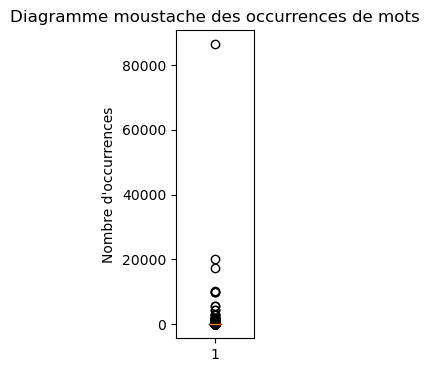

In [12]:
# Extraire les occurrences et les mots
occurrences_values = list(dictionnaire_minutes.values())
mots = list(dictionnaire_minutes.keys())

# Créer le diagramme en boîte (boxplot)
fig, ax = plt.subplots()
fig.set_size_inches(1, 4)
ax.boxplot(occurrences_values)

# Calculer la position des points extrêmes
outliers = ax.lines[5].get_ydata()

# Afficher les mots associés aux outliers (valeurs extrêmes)
for outlier in outliers:
    # Trouver le mot correspondant à la valeur d'occurrence
    mot_associe = [mot for mot, count in dictionnaire_minutes.items() if count == outlier]

# Ajouter un titre et des labels
plt.title('Diagramme moustache des occurrences des temps de cuisson')
plt.ylabel('Nombre d\'occurrences')

# Afficher le diagramme
plt.show()

In [13]:
#On enlève au dessus de  1000 min on garde toutes les recettes de moins de 24h (mijotage) et = à 0 min 
l = [] #liste des ids à enlever 
for i in dictionnaire_minutes.keys() :
    if dictionnaire_minutes[i] > 1000 :
        l.append(i)
    if dictionnaire_minutes[i] == 0 : #On supprime aussi les valeurs à 0 min
        l.append(i)

for i in l :
    del dictionnaire_minutes[i]

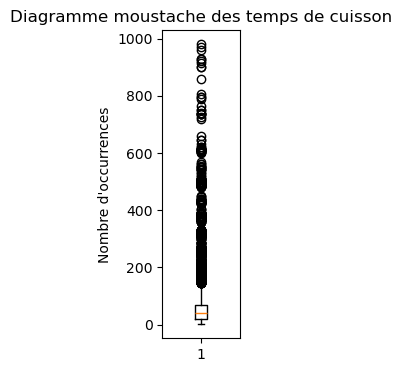

In [14]:
#On refait un moustache pour voir ce que ça donne 

# Extraire les occurrences et les mots
occurrences_values = list(dictionnaire_minutes.values())
mots = list(dictionnaire_minutes.keys())

# Créer le diagramme en boîte (boxplot)
fig, ax = plt.subplots()
fig.set_size_inches(1, 4)
ax.boxplot(occurrences_values)

# Calculer la position des points extrêmes
outliers = ax.lines[5].get_ydata()

# Afficher les mots associés aux outliers (valeurs extrêmes)
for outlier in outliers:
    # Trouver le mot correspondant à la valeur d'occurrence
    mot_associe = [mot for mot, count in dictionnaire_minutes.items() if count == outlier]

# Ajouter un titre et des labels
plt.title('Diagramme moustache des temps de cuisson')
plt.ylabel('Nombre d\'occurrences')

# Afficher le diagramme
plt.show()

In [15]:
intervals = [f"{i}-{i+5} minutes" for i in range(0, 20, 5)] + \
            [f"{i}-{i+10} minutes" for i in range(20, 60, 10)] + \
            ["1-2h", "2-3h", "au dessus de 3h"]

print(df['minutes'].dtype)

int64


In [16]:
df_pivot = pd.DataFrame({
    'intervalle': [i for i in range(182)],
    'Spring': [0 for i in range(182)],
    'Winter': [0 for i in range(182)],
    'Summer': [0 for i in range(182)],
    'Fall': [0 for i in range(182)],
}) #On initialise avec des valeurs aléatoires 

In [17]:
Liste_saisons = ['Spring','Winter','Summer','Fall']
liste_cook_times = [i for i in range(1,182)] #Un peu mal dit mais bon 

In [19]:
#Maintenant l'étape difficile

for i in Liste_saisons :
    for j in range(len(liste_cook_times)) :
        if(j==0) :
            count = df[(df['season'] == i) & (df['minutes'] <= liste_cook_times[j])]
        elif j < len(liste_cook_times)-1:
            count = df[(df['season'] == i) & (liste_cook_times[j-1]<= df['minutes'] ) & (df['minutes'] <= liste_cook_times[j])]
        else : 
            count = df[(df['season'] == i) & (df['minutes'] >= liste_cook_times[-1] )]
            print(f"[DEBUG] Saison: {i}, Intervalle: >= {liste_cook_times[-1]}, Lignes trouvées: {count.shape[0]}")

        df_pivot.loc[df_pivot['intervalle'] == liste_cook_times[j], i] = count.shape[0]



print(df_pivot)

[DEBUG] Saison: Spring, Intervalle: >= 181, Lignes trouvées: 83
[DEBUG] Saison: Winter, Intervalle: >= 181, Lignes trouvées: 290
[DEBUG] Saison: Summer, Intervalle: >= 181, Lignes trouvées: 98
[DEBUG] Saison: Fall, Intervalle: >= 181, Lignes trouvées: 162
     intervalle  Spring  Winter  Summer  Fall
0             0       0       0       0     0
1             1       4      11       8    20
2             2      11      20      20    10
3             3      11      23      23     6
4             4       9      16       9     4
..          ...     ...     ...     ...   ...
177         177       0       0       0     0
178         178       0       0       0     0
179         179       0       0       0     0
180         180       8       7      10     5
181         181      83     290      98   162

[182 rows x 5 columns]


In [21]:
#Pourcentages 

# Pour chaque saison, calcule le pourcentage des recettes dans chaque intervalle
for saison in ['Spring', 'Winter', 'Summer', 'Fall']:
    # Ajoute une nouvelle colonne pour les pourcentages
    df_pivot[f'{saison}_%'] = (df_pivot[saison] / df_pivot[['Spring', 'Winter', 'Summer', 'Fall']].sum(axis=1)) * 100

df_pivot['nb_recettes_total'] = (df_pivot['Summer']+df_pivot['Winter']+df_pivot['Spring']+df_pivot['Fall'])
# Affiche le résultat
print(df_pivot)

     intervalle  Spring  Winter  Summer  Fall   Spring_%   Winter_%  \
0             0       0       0       0     0        NaN        NaN   
1             1       4      11       8    20   9.302326  25.581395   
2             2      11      20      20    10  18.032787  32.786885   
3             3      11      23      23     6  17.460317  36.507937   
4             4       9      16       9     4  23.684211  42.105263   
..          ...     ...     ...     ...   ...        ...        ...   
177         177       0       0       0     0        NaN        NaN   
178         178       0       0       0     0        NaN        NaN   
179         179       0       0       0     0        NaN        NaN   
180         180       8       7      10     5  26.666667  23.333333   
181         181      83     290      98   162  13.112164  45.813586   

      Summer_%     Fall_%  nb_recettes_total  
0          NaN        NaN                  0  
1    18.604651  46.511628                 43  
2    3

In [ ]:
df_pivot = df_pivot.fillna(0)

df_pivot.to_pickle("webapp_assets/cursor2.pkl")